# UZOP projekt 2022./23.
Ova Jupyter bilježnica rezultat je projektnog rada u sklopu kolegija Uvod u znanost podacima na FER-u, ak. god. 2022./23. U sklopu projektnog zadatka zadan je članak s određenom temom iz područja znanosti o podacima, skupa sa svojim podacima koje je potrebno pripremiti, pomoću njih replicirati rezultate rada u članku te naposlijetku predložiti eventualna poboljšanja. U poglavljima koja slijede svi su ovi koraci prikazani uz prikladna objašnjenja.

Autor članka "Predicting NBA shots" na kojem se temelji ovaj projekt je Brett Meehan sa sveučilišta Stanford u SAD-u. Članak je javno dostupan na poveznici: http://cs229.stanford.edu/proj2017/final-reports/5132133.pdf. Članak istražuje primjenu različitih algoritama strojnog učenja na problem predviđanja uspješnosti bacanja igrača u NBA ligi.

## 1. Priprema i vizualizacija podataka
Prije bilo kakvog rada s podacima, potrebno je upoznati se s njima kako bismo ih mogli ispravno prikazati, koristiti i na temelju njih nešto zaključiti. Korištenje tzv. sirovih podataka u statističkoj analizi bez dubljeg promišljanja o njima može prouzročiti razne probleme, samo neki od kojih su neispravno postavljanje cilja analize, rušenje algoritama strojnog učenja te na koncu i donošenje neispravnih zaključaka.

Priprema podataka podrazumijeva njihovu pripremu za daljnju analizu. Tek nakon provedene pripreme možemo podatke organizirati i eventualno upotpuniti ukoliko ima nedostajućih vrijednosti. Naposlijetku je podatke poželjno vizualizirati.

### 1.1 Učitavanje osnovnih biblioteka


In [339]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 1.2 Učitavanje podataka
Podaci su nam dostupni u obliku CSV datoteke `shot_logs.csv`.

In [340]:
dataset = pd.read_csv("shot_logs.csv")

### 1.3 Početni pregled podataka

Pomoću atributa `shape` možemo doznati dimenzije skupa podataka - u našem slučaju, to su dvije dimenzija: broj redaka (primjera) i broj stupaca (značajki).

In [341]:
dataset.shape

(128069, 21)

Funkcija `head(n=5)` iz paketa `Pandas` omogućuje nam prikaz prvih `n` redaka iz skupa podataka.

In [342]:
dataset.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


Kako naš skup podataka ima dvije dimenzije, njegovo svojstvo `columns` ima atribut `values` preko kojeg doznajemo nazive svih značajki u našem skupu podataka. Ovo nam je važno jer ćemo neke značajke morati izbaciti, a neke će nam pak biti važnije od ostalih u predviđanjima nad skupom podataka.

In [343]:
dataset.columns.values

array(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN',
       'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES',
       'TOUCH_TIME', 'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT',
       'CLOSEST_DEFENDER', 'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST',
       'FGM', 'PTS', 'player_name', 'player_id'], dtype=object)

U nastavku su dana pojašnjenja naziva pojedinih značajki:
- `GAME_ID` - identifikacijska oznaka utakmice
- `MATCHUP` - "naziv" utakmice, koji uključuje datum i imena suprotstavljenih timova
- `LOCATION` - lokacija na kojoj je odigrana utakmica, može biti `H` (_home_) ili `A` (_away_)
- `W` - ishod utakmice, može biti `W` (_win_) ili `L` (_loss_)
- `FINAL_MARGIN` - razlika u ostvarenim poenima između pobjedničkog i gubitničkog tima na kraju utakmice
- `SHOT_NUMBER` - redni broj pucanja za dotičnog igrača
- `PERIOD` - dio utakmice, može biti prirodan broj iz skupa {1, 2, 3, 4} i označava redni broj četvrtine
- `GAME_CLOCK` - vrijeme u trenutku pucanja na satu koji označava preostalo vrijeme do kraja trenutne četvrtine
- `SHOT_CLOCK` - vrijeme u trenutku pucanja na satu koji označava preostalo vrijeme za napad
- `DRIBBLES` - broj driblanja igrača prije pucanja na koš
- `TOUCH_TIME` - mjera vremena koliko je lopta provela u igračevom posjedu
- `SHOT_DIST` - udaljenost mjesta pucanja od koša
- `PTS_TYPE` - vrsta pucanja koja zapravo označava broj poena koje igrač osvaja za svoj tim u slučaju pogotka, može biti prirodan broj iz skupa {2, 3}
- `SHOT_RESULT` - ishod pucanja, može biti `made` (pogodak) ili `missed` (promašaj)
- `CLOSEST_DEFENDER` - ime protivničkog obrambenog igrača koji se u trenutku pucanja nalazio najbliže igraču koji puca
- `CLOSEST_DEFENDER_PLAYERID` - id protivničkog obrambenog igrača koji se u trenutku pucanja nalazio najbliže igraču koji puca
- `CLOSE_DEF_DIST` - udaljenost najbližeg protivničkog obrambenog igrača od igrača koji puca
- `FGM` - označava je li postignut pogodak koji nije iz slobodnog bacanja, može biti `1` (pogodak postignut) ili `0` (pogodak nije postignut)
- `PTS` - ostvareni broj poena za pogodak, može biti cijeli broj iz skupa {0, 1, 2, 3}
- `player_name` - ime igrača koji puca
- `player_id` - identifikacijska oznaka igrača koji puca

U nastavku su pomoću funkcije `describe()` dane neke osnovne deskriptivne statistike nad skupom podataka.

In [344]:
dataset.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


In [345]:
dataset.nunique()

GAME_ID                        904
MATCHUP                       1808
LOCATION                         2
W                                2
FINAL_MARGIN                    88
SHOT_NUMBER                     38
PERIOD                           7
GAME_CLOCK                     719
SHOT_CLOCK                     241
DRIBBLES                        33
TOUCH_TIME                     313
SHOT_DIST                      448
PTS_TYPE                         2
SHOT_RESULT                      2
CLOSEST_DEFENDER               473
CLOSEST_DEFENDER_PLAYER_ID     474
CLOSE_DEF_DIST                 299
FGM                              2
PTS                              3
player_name                    281
player_id                      281
dtype: int64

Podatke koji nam ne mogu pomoći u statističkoj analizi podataka potrebno je izbaciti iz skupa. Kandidati za izbacivanje su `MATCHUP` (jer je to samo naziv utakmice za koju već imamo jedinstveni identifikator), `CLOSEST_DEFENDER` (jer je to ime igrača za kojeg imamo jedinstveni identifikator) i `player_name` (isto opravdanje).

In [346]:
dataset.drop(('MATCHUP'), axis=1, inplace=True)
dataset.drop(('CLOSEST_DEFENDER'), axis=1, inplace=True)
dataset.drop(('player_name'), axis=1, inplace=True)

Također, može se argumentirati da najbližeg obrambenog igrača možemo u potpunosti izbaciti te gledati samo njegovu udaljenost od igrača koji puca. Razlog tomu je što nemamo puno konzistentnih podataka - npr. da se svi zapisi u skupu odnose na jednog igrača i njegova pucanja, ili barem igrače iz istog tima, imalo bi smisla promatrati protiv kojih obrambenih igrača oni bolje odnosno lošije funkcioniraju u napadu.

In [347]:
dataset.drop(('CLOSEST_DEFENDER_PLAYER_ID'), axis=1, inplace=True)

In [348]:
dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,W,24,3,1,0:00,NaN,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


### 1.4 Preoblikovanje podataka
U skupu podataka ima nedostajućih vrijednosti, što otežava kasniju obradu i vizualizaciju. Nekoliko je načina razrješavanja nedostajućih vrijednosti u skupu podataka: izbacivanje zapisa iz skupa podataka, izbacivanje značajke iz skupa podataka, zamjena srednjom vrijednošću preostalih vrijednosti, pronalazak točnih vrijednosti na drugim mjestima itd.

Možemo pronaći nedostajuće vrijednosti u našem skupu podataka pomoću funkcije `isna()` koja traži vrijednosti `NaN` u skupu podataka. Broj pojavljivanja takvih vrijednosti pobrojimo po značajkama pomoću funkcije `sum()`.

In [349]:
dataset.isna().sum()

GAME_ID              0
LOCATION             0
W                    0
FINAL_MARGIN         0
SHOT_NUMBER          0
PERIOD               0
GAME_CLOCK           0
SHOT_CLOCK        5567
DRIBBLES             0
TOUCH_TIME           0
SHOT_DIST            0
PTS_TYPE             0
SHOT_RESULT          0
CLOSE_DEF_DIST       0
FGM                  0
PTS                  0
player_id            0
dtype: int64

Vidimo da u našem skupu podataka značajka `SHOT_CLOCK` ima nedostajućih vrijednosti.

In [350]:
dataset_shotClockNaN = dataset[dataset["SHOT_CLOCK"].isna()]
dataset_shotClockNaN.loc[:, ["GAME_CLOCK", "SHOT_CLOCK"]]

,GAME_CLOCK,SHOT_CLOCK
2,0:00,NaN
24,0:04,NaN
54,0:01,NaN
76,0:01,NaN
129,0:02,NaN
...,...,...
128008,0:02,NaN
128017,0:03,NaN
128018,0:02,NaN
128051,0:16,NaN


Iz navedenog prikaza možemo zaključiti da se _shot clock_ više ne resetira nakon što _game clock_ vrijednost padne ispod 24 sekunde. Nakon što dođe do nule, shot clock se ugasi jer igrači od tog trenutka više nemaju 24 sekunde na raspolaganju za napad, već onoliko koliko je preostalo do kraja četvrtine.

Vrijednosti `NaN` u stupcu značajke `SHOT_CLOCK` možemo zamijeniti vrijednošću značajke `GAME_CLOCK`. Nema smisla izbacivati te zapise iz skupa podataka jer ih ima puno, a značajku pogotovo nema smisla izbacivati jer igrači imaju tendenciju pucati kada je vrijednost na _shot clocku_ mala.

In [351]:
mask = (dataset['SHOT_CLOCK'].isna())
dataset.loc[mask, "SHOT_CLOCK"] = dataset.loc[mask, "GAME_CLOCK"]

dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,W,24,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,W,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,W,24,3,1,0:00,0:00,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,W,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,W,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


Vidimo da u stupcu `SHOT_CLOCK` više nema nedostajućih vrijednosti, već su one sada zamijenjene vrijednošću iz stupca `GAME_CLOCK`.

Neke značajke ne možemo koristiti u statističkoj analizi kao takve, već im vrijednosti moramo postaviti u numeričke, odnosno brojeve. Na primjer, značajka `W` poprima vrijednosti `W` i `L`, što lako možemo preoblikovati u `1` i `0`.

In [352]:
mask = (dataset['W'] == 'W')
dataset.loc[mask, "W"] = 1

mask = (dataset['W'] == 'L')
dataset.loc[mask, "W"] = 0

dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,A,1,24,1,1,1:09,10.8,2,1.9,7.7,2,made,1.3,1,2,203148
1,21400899,A,1,24,2,1,0:14,3.4,0,0.8,28.2,3,missed,6.1,0,0,203148
2,21400899,A,1,24,3,1,0:00,0:00,3,2.7,10.1,2,missed,0.9,0,0,203148
3,21400899,A,1,24,4,2,11:47,10.3,2,1.9,17.2,2,missed,3.4,0,0,203148
4,21400899,A,1,24,5,2,10:34,10.9,2,2.7,3.7,2,missed,1.1,0,0,203148


Isto možemo učiniti i sa značajkama `LOCATION` i `SHOT_RESULT`.

In [353]:
mask = (dataset['LOCATION'] == 'H')
dataset.loc[mask, "LOCATION"] = 1

mask = (dataset['LOCATION'] == 'A')
dataset.loc[mask, "LOCATION"] = 0

mask = (dataset['SHOT_RESULT'] == 'made')
dataset.loc[mask, "SHOT_RESULT"] = 1

mask = (dataset['SHOT_RESULT'] == 'missed')
dataset.loc[mask, "SHOT_RESULT"] = 0

dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,FGM,PTS,player_id
0,21400899,0,1,24,1,1,1:09,10.8,2,1.9,7.7,2,1,1.3,1,2,203148
1,21400899,0,1,24,2,1,0:14,3.4,0,0.8,28.2,3,0,6.1,0,0,203148
2,21400899,0,1,24,3,1,0:00,0:00,3,2.7,10.1,2,0,0.9,0,0,203148
3,21400899,0,1,24,4,2,11:47,10.3,2,1.9,17.2,2,0,3.4,0,0,203148
4,21400899,0,1,24,5,2,10:34,10.9,2,2.7,3.7,2,0,1.1,0,0,203148


Sada kada smo "numerizirali" značajku `SHOT_MADE`, možemo argumentirati izbacivanje značajke `FGM` pošto ona označava je li postignut pogodak koji nije bio rezultat slobodnog bacanja, što nam je manje važno od činjenice da je igrač postigao pogodak.

In [354]:
dataset.drop(('FGM'), axis=1, inplace=True)

In [355]:
dataset.head()

,GAME_ID,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSE_DEF_DIST,PTS,player_id
0,21400899,0,1,24,1,1,1:09,10.8,2,1.9,7.7,2,1,1.3,2,203148
1,21400899,0,1,24,2,1,0:14,3.4,0,0.8,28.2,3,0,6.1,0,203148
2,21400899,0,1,24,3,1,0:00,0:00,3,2.7,10.1,2,0,0.9,0,203148
3,21400899,0,1,24,4,2,11:47,10.3,2,1.9,17.2,2,0,3.4,0,203148
4,21400899,0,1,24,5,2,10:34,10.9,2,2.7,3.7,2,0,1.1,0,203148


### 1.5 Vizualizacija podataka
Vizualizacija podataka omogućuje nam otkrivanje odnosa među varijablama i primjercima te bolje razumijevanja rezultata analize. Vrlo je bitna za općenito razumijevanje skupa podataka s kojim raspolažemo pa je samim time neizostavan dio pregleda podataka.

Za početak ćemo pokušati detektirati stršeće vrijednosti u skupu podataka. To možemo učiniti pomoću funkcije `boxplot()`.

Text(0.5, 1.0, 'Closest defender distance')

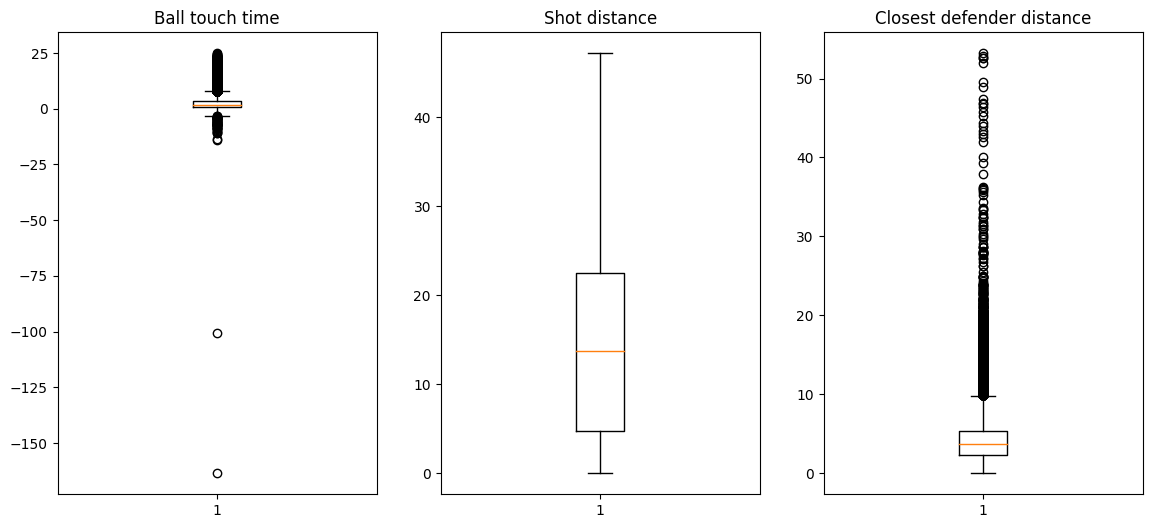

In [356]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(14, 6)
ax[0].boxplot(dataset['TOUCH_TIME'])
ax[0].set_title("Ball touch time")
ax[1].boxplot(dataset['SHOT_DIST'])
ax[1].set_title("Shot distance")
ax[2].boxplot(dataset['CLOSE_DEF_DIST'])
ax[2].set_title("Closest defender distance")

Provjerit ćemo i koje bi vrijednosti mogle biti korelirane na temelju matrice korelacija koju dobijemo pomoću funkcije `corr()`.

In [357]:
dataset.corr()

/var/folders/n_/4mscf3ld1n9g7nqmvt59wr3c0000gn/T/ipykernel_20579/2191645083.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  dataset.corr()


,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSE_DEF_DIST,PTS,player_id
GAME_ID,1.000000,0.001726,0.008129,-0.008921,0.002014,-0.000735,-0.000187,0.003418,0.006739,-0.008464,0.027937
FINAL_MARGIN,0.001726,1.000000,0.000836,-0.003078,0.011739,0.010788,0.008876,0.024134,0.033064,0.064784,-0.050825
SHOT_NUMBER,0.008129,0.000836,1.000000,0.654932,0.141100,0.144071,0.011541,0.003054,-0.037769,-0.009666,-0.006592
PERIOD,-0.008921,-0.003078,0.654932,1.000000,0.055301,0.046089,0.030080,0.048915,-0.010204,-0.008501,0.004790
DRIBBLES,0.002014,0.011739,0.141100,0.055301,1.000000,0.914311,-0.082540,-0.169016,-0.153674,-0.055689,0.023655
TOUCH_TIME,-0.000735,0.010788,0.144071,0.046089,0.914311,1.000000,-0.085165,-0.181007,-0.164737,-0.066736,0.001797
SHOT_DIST,-0.000187,0.008876,0.011541,0.030080,-0.082540,-0.085165,1.000000,0.740933,0.523192,-0.069147,-0.024270
PTS_TYPE,0.003418,0.024134,0.003054,0.048915,-0.169016,-0.181007,0.740933,1.000000,0.414198,0.030361,0.010486
CLOSE_DEF_DIST,0.006739,0.033064,-0.037769,-0.010204,-0.153674,-0.164737,0.523192,0.414198,1.000000,0.063612,0.008483
PTS,-0.008464,0.064784,-0.009666,-0.008501,-0.055689,-0.066736,-0.069147,0.030361,0.063612,1.000000,-0.003276


Ovo se još bolje vidi ako koristimo tzv. _heatmap_ funkcije.

/var/folders/n_/4mscf3ld1n9g7nqmvt59wr3c0000gn/T/ipykernel_20579/89618658.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(dataset_numeric.corr())


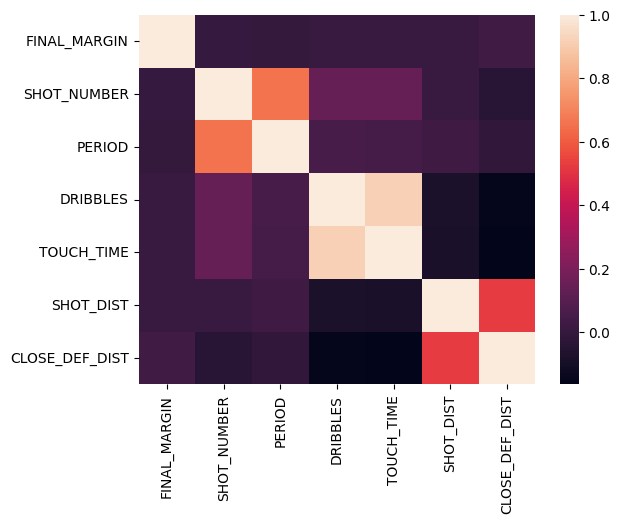

In [358]:
dataset_numeric = dataset.loc[:,dataset.columns.isin(['FINAL_MARGIN', 'SHOT_NUMBER', 'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME', 'SHOT_DIST', 'CLOSE_DEF_DIST'])]
sns.heatmap(dataset_numeric.corr())
plt.show()

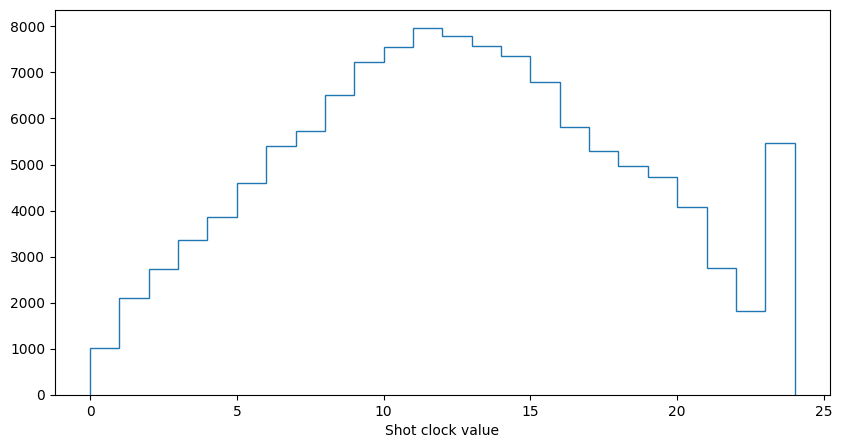

In [359]:
dataset['SHOT_CLOCK'] = pd.to_numeric(dataset['SHOT_CLOCK'],errors='coerce')

plt.figure(figsize=(10,5))
plt.hist(dataset['SHOT_CLOCK'], bins=24, histtype='step')
plt.xlabel('Shot clock value')
plt.show()

Vidimo da igrači imaju tendenciju pucati kada se vrijeme za napad približava kraju, što ima smisla jer žele iskoristiti priliku za postizanje pogotka.